<a href="https://colab.research.google.com/github/dbtmddn41/deep_learning/blob/main/kaggle/plant_pathology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = '딥러닝/kaggle/plant\ pathology'

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/My Drive/딥러닝/kaggle/plant pathology


In [ ]:
!mkdir -p ~/.kaggle
!cp ../kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c plant-pathology-2020-fgvc7

!unzip -o plant-pathology-2020-fgvc7.zip

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers

# 데이터 둘러보기

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [ ]:
print(train.shape, test.shape)

(1821, 5) (1821, 1)


In [ ]:
train.head()

image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

In [ ]:
submission.head()

image_id  healthy  multiple_diseases  rust  scab
0   Test_0     0.25               0.25  0.25  0.25
1   Test_1     0.25               0.25  0.25  0.25
2   Test_2     0.25               0.25  0.25  0.25
3   Test_3     0.25               0.25  0.25  0.25
4   Test_4     0.25               0.25  0.25  0.25

In [ ]:
healthy = train.loc[train['healthy']==1]
multi_diseases = train.loc[train['multiple_diseases']==1]
rust = train.loc[train['rust']==1]
scab = train.loc[train['scab']==1]


([<matplotlib.patches.Wedge at 0x7f08466c0fd0>,
 [Text(0.6921787180836257, 0.8549202431993926, 'healthy'),
  Text(-0.3942932497177081, 1.0269044908008969, 'multiple_diseases'),
  Text(-1.0996317038245758, -0.028462535794632142, 'rust'),
  Text(0.5744651016901711, -0.9380777403499678, 'scab')],
 [Text(0.377552028045614, 0.4663201326542141, '28.3%'),
  Text(-0.21506904530056806, 0.5601297222550347, '5.0%'),
  Text(-0.5997991111770412, -0.015525019524344801, '34.2%'),
  Text(0.31334460092191146, -0.5116787674636187, '32.5%')])

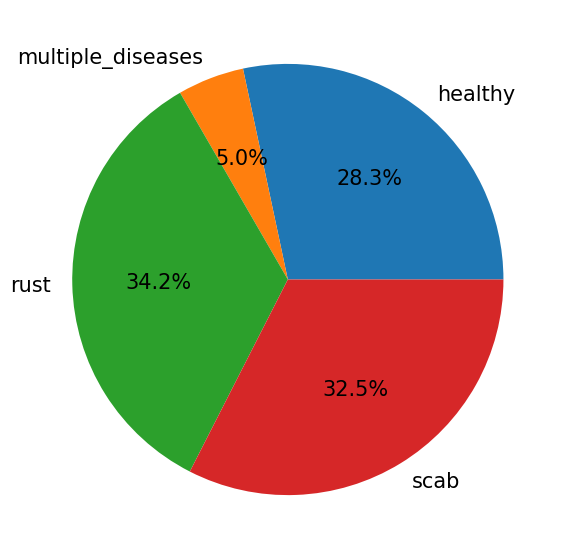

In [ ]:
mpl.rc('font', size=15)
plt.figure(figsize=(7,7))

label = sorted(list(train))
label.remove('image_id')
plt.pie([len(healthy), len(multi_diseases), len(rust), len(scab)], labels=label, autopct="%.1f%%")

In [ ]:
import matplotlib.gridspec as gridspec
import cv2

def show_image(img_ids, title, rows=2, cols=3):
    assert len(img_ids) <= rows*cols

    plt.figure(figsize=(15,8))
    grid = gridspec.GridSpec(rows, cols)

    plt.title(title)
    for idx, img_id in enumerate(img_ids):
        img_path = f'images/{img_id}.jpg'
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax = plt.subplot(grid[idx])
        ax.axis('off')
        ax.imshow(img)

<ipython-input-11-29d2e527b2cf>:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(grid[idx])


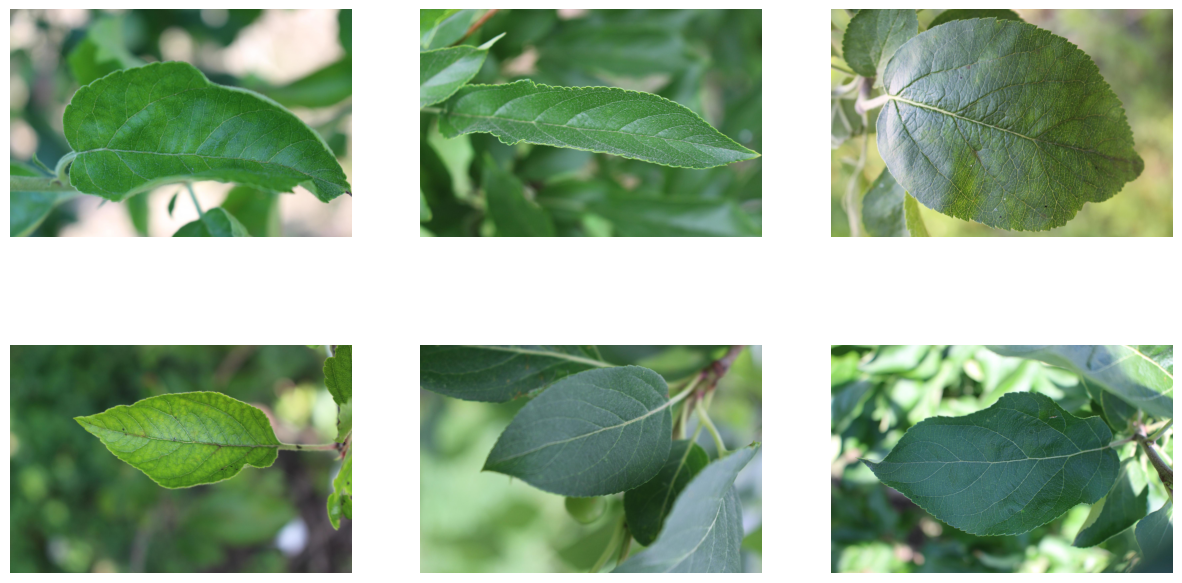

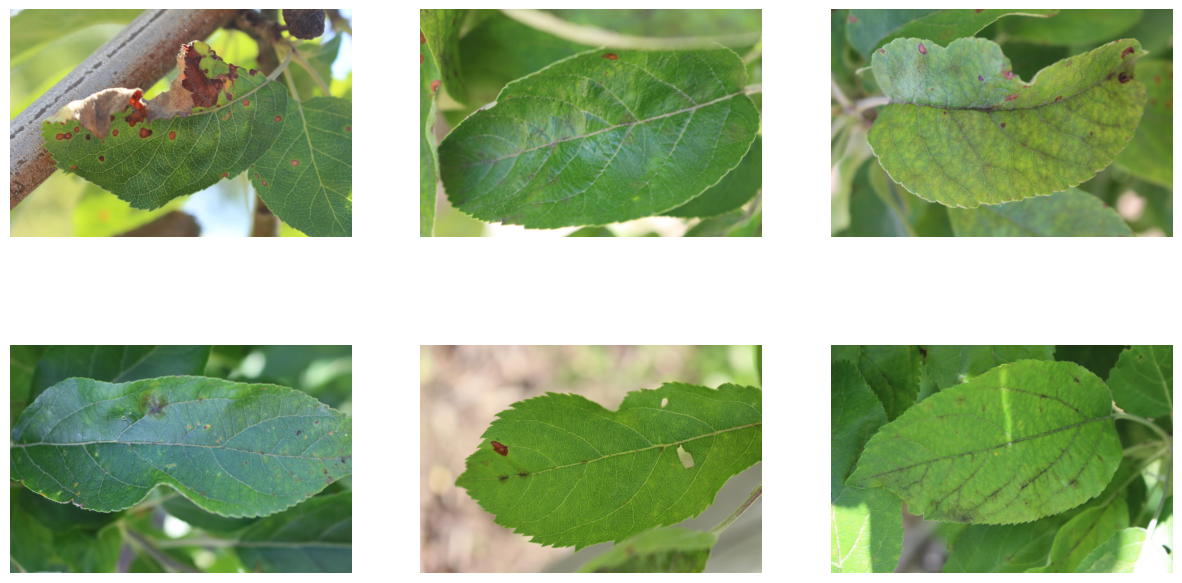

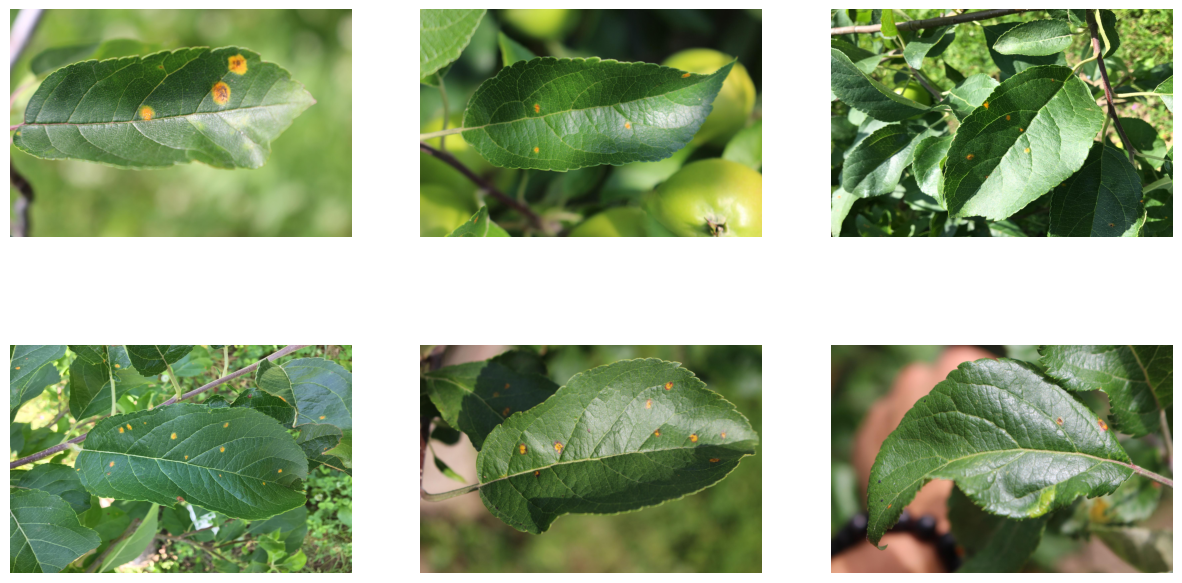

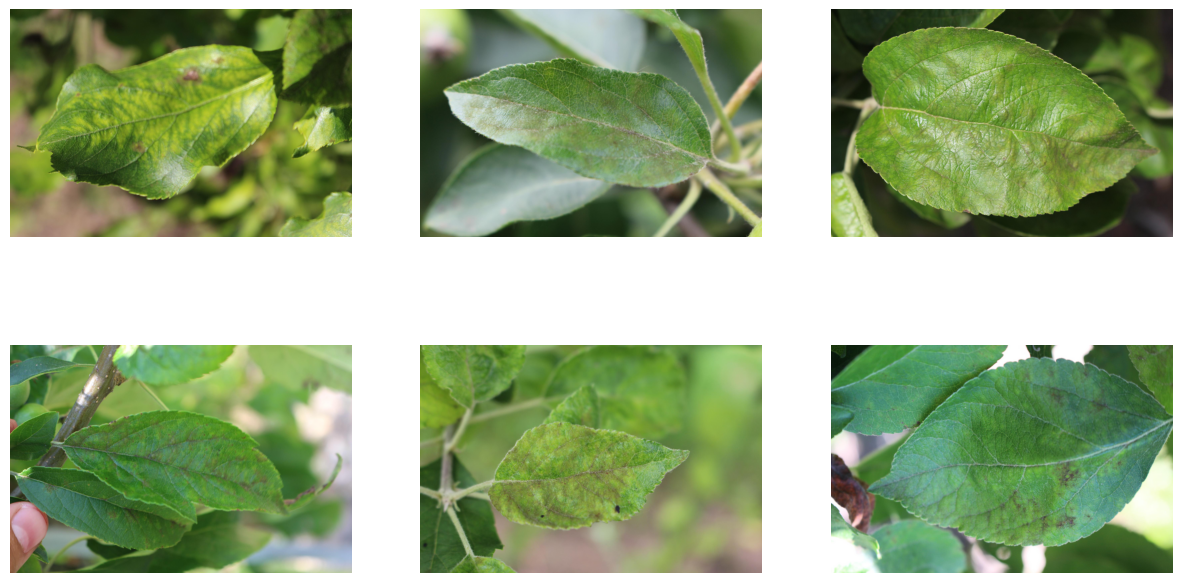

In [ ]:
num_imgs=6
show_image(healthy['image_id'][:num_imgs], 'healthy')
show_image(multi_diseases['image_id'][:num_imgs], 'multi_diseases')
show_image(rust['image_id'][:num_imgs], 'rust')
show_image(scab['image_id'][:num_imgs], 'scab')


In [ ]:
img = train['image_id'][0]
print(cv2.imread(f'images/{img}.jpg').shape)

img = train['image_id'][1]
print(cv2.imread(f'images/{img}.jpg').shape)

(1365, 2048, 3)
(1365, 2048, 3)


In [ ]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(train, test_size=0.05, stratify=train[label], random_state=42)
num_train = len(train_data)
num_val = len(val_data)
print(num_train, num_val)

1729 92


In [ ]:
import os, shutil, pathlib

# if 'plant_train' in os.listdir():
#     shutil.rmtree('plant_train/')

origin_dir = pathlib.Path("images")
new_base_dir = pathlib.Path("plant_train")
# def make_subset(subset_name, df, labels):
#     for i, category in enumerate(labels):
#         dir = new_base_dir / subset_name / category
#         os.makedirs(dir)
#         fnames = df[df[category]==1]['image_id']
#         for fname in fnames:
#             shutil.copyfile(src=origin_dir/(fname+'.jpg'), dst=dir/(fname+'.jpg'))

# make_subset("train", train_data, label)
# make_subset("validation", val_data, label)

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

batch_size = 256
img_size = (480,480)
train_dataset = image_dataset_from_directory(new_base_dir / 'train', label_mode='categorical', class_names=label, image_size=img_size,seed=42, batch_size=batch_size)
val_dataset = image_dataset_from_directory(new_base_dir / 'validation', label_mode='categorical', class_names=label, image_size=img_size, seed=42, batch_size=batch_size)

Found 1729 files belonging to 4 classes.
Found 92 files belonging to 4 classes.


In [ ]:
for img, target in train_dataset.take(1):
    print(img.shape, target.shape)

(64, 480, 480, 3) (64, 4)


# 모델 만들기

In [ ]:
data_augment = keras.Sequential([
    layers.RandomBrightness(0.2, value_range=(0, 255), seed=42),
    layers.RandomContrast(0.2, seed=43),
    layers.RandomFlip(mode='horizontal_and_vertical', seed=44),
    layers.RandomRotation(0.1, seed=45),
    layers.RandomZoom(0.2, seed=46),
    layers.RandomTranslation(0.1, 0.1, seed=47)
])

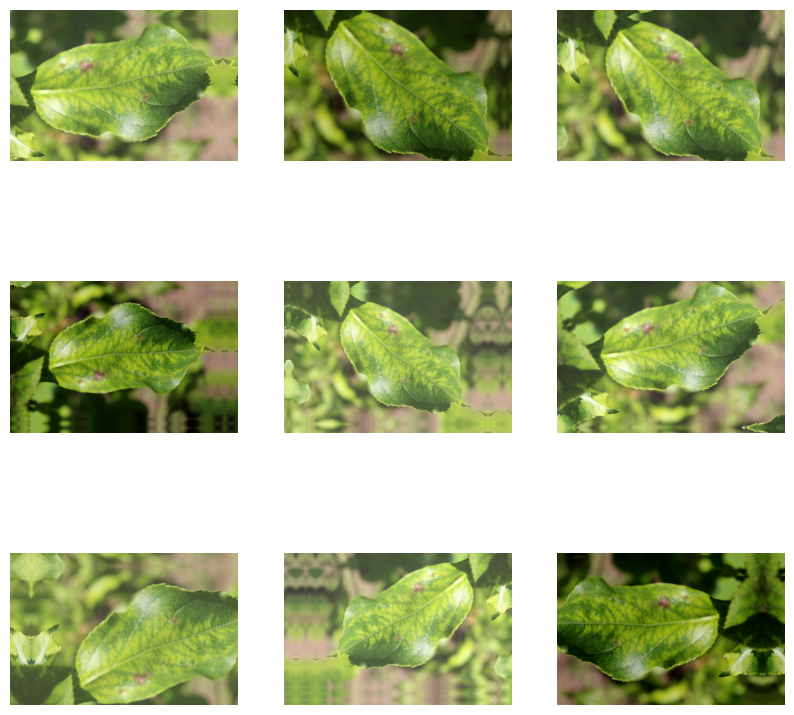

In [ ]:
img = cv2.imread('images/Train_0.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augment(img)
  ax = plt.subplot(3, 3, i + 1)
  ax.axis('off')
  ax.imshow(tf.cast(augmented_image, tf.int32))

In [ ]:
#GPU 쓸 때만 빠르다.
keras.mixed_precision.set_global_policy('mixed_float16')
# keras.mixed_precision.set_global_policy('float16')

## unfreeze

In [ ]:
def get_model(epochs):
    eff_cnn = keras.applications.EfficientNetV2M(
        include_top=False,
        weights="imagenet",
        input_shape=(*img_size, 3),
        pooling='avg'
    )

    eff_cnn.trainable = True
    # for layer in eff_cnn.layers[-4:]:
    #     layer.trainable = True

    inputs = keras.Input(shape=(*img_size, 3))
    augmented_image = data_augment(inputs)
    x = eff_cnn(augmented_image)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(800, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(4, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    lr_schedule = keras.optimizers.schedules.CosineDecay(initial_learning_rate=1e-4, decay_steps=len(train_dataset)*epochs)

    optimizer = keras.optimizers.experimental.AdamW(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath='best_model_unfreeze.keras', save_best_only=True, monitor='val_loss'),
             keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)]
epochs = 50

model = get_model(epochs)
model.fit(train_dataset.prefetch(tf.data.AUTOTUNE), epochs=epochs, callbacks=callbacks, validation_data=val_dataset.prefetch(tf.data.AUTOTUNE))


Epoch 1/50
433/433 [==============================] - 266s 203ms/step - loss: 0.6066 - accuracy: 0.7970 - val_loss: 0.1830 - val_accuracy: 0.9239
Epoch 2/50
433/433 [==============================] - 91s 210ms/step - loss: 0.3330 - accuracy: 0.8924 - val_loss: 0.1801 - val_accuracy: 0.9239
Epoch 3/50
433/433 [==============================] - 91s 209ms/step - loss: 0.2517 - accuracy: 0.9184 - val_loss: 0.1356 - val_accuracy: 0.9457
Epoch 4/50
433/433 [==============================] - 76s 175ms/step - loss: 0.2202 - accuracy: 0.9358 - val_loss: 0.2640 - val_accuracy: 0.9239
Epoch 5/50
433/433 [==============================] - 76s 175ms/step - loss: 0.1997 - accuracy: 0.9370 - val_loss: 0.2629 - val_accuracy: 0.9130
Epoch 6/50
433/433 [==============================] - 90s 207ms/step - loss: 0.1647 - accuracy: 0.9439 - val_loss: 0.1162 - val_accuracy: 0.9457
Epoch 7/50
433/433 [==============================] - 90s 207ms/step - loss: 0.1701 - accuracy: 0.9479 - val_loss: 0.0569 - val_a

## freeze

In [ ]:
def get_model(epochs):
    eff_cnn = keras.applications.EfficientNetV2M(
        include_top=False,
        weights="imagenet",
        input_shape=(*img_size, 3),
        pooling='avg'
    )

    eff_cnn.trainable = False
    for layer in eff_cnn.layers[-49:]:
        layer.trainable = True

    inputs = keras.Input(shape=(*img_size, 3))
    augmented_image = data_augment(inputs)
    x = eff_cnn(augmented_image)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(1000, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(500, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(4, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    lr_schedule = keras.optimizers.schedules.CosineDecay(initial_learning_rate=5e-3, decay_steps=len(train_dataset)*epochs)

    optimizer = keras.optimizers.experimental.AdamW(learning_rate=lr_schedule)
    optimizer = keras.optimizers.Adam(learning_rate=5e-3)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath='best_model_freeze.keras', save_best_only=True, monitor='val_loss'),
             keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)]
epochs = 50

model = get_model(epochs)
history = model.fit(train_dataset.prefetch(tf.data.AUTOTUNE), epochs=epochs, callbacks=callbacks, validation_data=val_dataset.prefetch(tf.data.AUTOTUNE))


Epoch 1/50
7/7 [==============================] - 41s 2s/step - loss: 1.6355 - accuracy: 0.4893 - val_loss: 0.8799 - val_accuracy: 0.7609
Epoch 2/50
7/7 [==============================] - 10s 1s/step - loss: 0.7892 - accuracy: 0.7068 - val_loss: 0.6187 - val_accuracy: 0.8043
Epoch 3/50
7/7 [==============================] - 10s 1s/step - loss: 0.6572 - accuracy: 0.7715 - val_loss: 0.5483 - val_accuracy: 0.8261
Epoch 4/50
7/7 [==============================] - 10s 1s/step - loss: 0.6066 - accuracy: 0.7889 - val_loss: 0.4836 - val_accuracy: 0.7935
Epoch 5/50
7/7 [==============================] - 10s 1s/step - loss: 0.5818 - accuracy: 0.7872 - val_loss: 0.4783 - val_accuracy: 0.8152
Epoch 6/50


# 정답 제출

In [ ]:
best_model = keras.models.load_model('best_model_unfreeze.keras')
best_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 480, 480, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (1365, 2048, 3)           0         
                                                                 
 efficientnetv2-m (Functiona  (None, 1280)             53150388  
 l)                                                              
                                                                 
 dropout_10 (Dropout)        (None, 1280)              0         
                                                                 
 dense_10 (Dense)            (None, 800)               1024800   
                                                                 
 dropout_11 (Dropout)        (None, 800)               0         
                                                           

In [ ]:
class modified_best_model(keras.Model):
    def __init__(self, exist_model):
        super().__init__()
        self.f = []

        for layer in exist_model.layers:
            if not isinstance(layer, keras.Sequential):
                self.f.append(layer)

        self.f = keras.Sequential(self.f)

    def call(self, inputs):
        return self.f(inputs)

m_best_model = modified_best_model(best_model)

In [ ]:
m_best_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
m_best_model.evaluate(val_dataset)

1/1 [==============================] - 40s 40s/step - loss: 0.0522 - accuracy: 0.9891


[0.052154541015625, 0.989130437374115]

In [ ]:
from sklearn.metrics import roc_auc_score
import cv2
from tqdm import tqdm

validation_imgs = []
resize_layer = layers.Resizing(*img_size)
for img_name in tqdm(val_data['image_id']):
    img_path = 'images/' + img_name + '.jpg'
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = resize_layer(image)
    validation_imgs.append(image)

pred = m_best_model.predict(np.array(validation_imgs))
print(roc_auc_score(val_data[label], pred))

100%|██████████| 92/92 [00:03<00:00, 25.54it/s]


3/3 [==============================] - 10s 1s/step
0.9987183695302005


In [ ]:
test_imgs = []
resize_layer = layers.Resizing(*img_size)
for img_name in tqdm(submission['image_id']):
    img_path = 'images/' + img_name + '.jpg'
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = resize_layer(image)
    test_imgs.append(image)

pred = m_best_model.predict(np.array(test_imgs))


100%|██████████| 1821/1821 [01:22<00:00, 22.08it/s]


57/57 [==============================] - 25s 434ms/step


In [ ]:
submission[label] = pred
submission.head()

image_id   healthy  multiple_diseases          rust          scab
0   Test_0  0.000051           0.000049  1.000000e+00  1.668930e-06
1   Test_1  0.000001           0.000002  1.000000e+00  5.960464e-08
2   Test_2  0.000003           0.000004  2.980232e-07  1.000000e+00
3   Test_3  0.999512           0.000043  2.020597e-05  4.751682e-04
4   Test_4  0.000003           0.000014  1.000000e+00  2.980232e-07

In [ ]:
submission.to_csv('submission.csv', index=False)

## TTA

In [ ]:
data_augment = keras.Sequential([
    layers.RandomBrightness(0.2, value_range=(0, 255), seed=42),
    layers.RandomContrast(0.2, seed=43),
    layers.RandomFlip(mode='horizontal_and_vertical', seed=44),
    layers.RandomRotation(0.1, seed=45),
    layers.RandomZoom(0.2, seed=46),
    layers.RandomTranslation(0.1, 0.1, seed=47)
])

resize_layer = layers.Resizing(*img_size)

In [ ]:
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import cv2

num_augment = 8

validation_imgs = []
resize_layer = layers.Resizing(*img_size)
for img_name in tqdm(val_data['image_id']):
    img_path = 'images/' + img_name + '.jpg'
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = resize_layer(image)
    for i in range(num_augment):
        aug_image = data_augment(image)
        validation_imgs.append(aug_image)

pred = m_best_model.predict(np.array(validation_imgs))

pred_avg = pred.reshape(len(val_data), num_augment, -1).mean(axis=1)

print(roc_auc_score(val_data[label], pred_avg))

0.0
1.0


In [ ]:
num_augment = 8

resize_layer = layers.Resizing(*img_size)

test_imgs = []
pred_avg = np.zeros((len(submission), 4))

for i, img_name in enumerate(tqdm(submission['image_id'])):
    if i % 100 == 0:
        if i != 0:
            pred = m_best_model.predict(np.array(test_imgs))
            pred_avg[i-100:i] = pred.reshape(len(pred)//num_augment, num_augment, -1).mean(axis=1)
        test_imgs = []
    img_path = 'images/' + img_name + '.jpg'
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = resize_layer(image)
    for j in range(num_augment):
        aug_image = data_augment(image)
        test_imgs.append(aug_image)


pred = m_best_model.predict(np.array(test_imgs))
pred_avg[len(submission)-len(pred)//num_augment:] = pred.reshape(len(pred)//num_augment, num_augment, -1).mean(axis=1)

  5%|▌         | 100/1821 [00:34<09:58,  2.88it/s]

25/25 [==============================] - 10s 414ms/step


 11%|█         | 200/1821 [01:25<09:17,  2.91it/s]

25/25 [==============================] - 10s 407ms/step


 16%|█▋        | 300/1821 [02:14<08:39,  2.93it/s]

25/25 [==============================] - 10s 410ms/step


 22%|██▏       | 400/1821 [03:04<08:01,  2.95it/s]

25/25 [==============================] - 10s 407ms/step


 27%|██▋       | 500/1821 [03:54<07:37,  2.89it/s]

25/25 [==============================] - 10s 410ms/step


 33%|███▎      | 600/1821 [04:55<07:48,  2.60it/s]

25/25 [==============================] - 10s 412ms/step


 38%|███▊      | 700/1821 [05:45<06:20,  2.94it/s]

25/25 [==============================] - 10s 409ms/step


 44%|████▍     | 800/1821 [06:35<05:49,  2.92it/s]

25/25 [==============================] - 10s 409ms/step


 49%|████▉     | 900/1821 [07:24<05:15,  2.91it/s]

25/25 [==============================] - 10s 410ms/step


 55%|█████▍    | 1000/1821 [08:14<04:38,  2.95it/s]

25/25 [==============================] - 10s 409ms/step


 60%|██████    | 1100/1821 [09:04<04:10,  2.88it/s]

25/25 [==============================] - 10s 409ms/step


 66%|██████▌   | 1200/1821 [09:54<03:30,  2.95it/s]

25/25 [==============================] - 10s 409ms/step


 71%|███████▏  | 1300/1821 [10:44<03:04,  2.82it/s]

25/25 [==============================] - 10s 408ms/step


 77%|███████▋  | 1400/1821 [11:33<02:24,  2.92it/s]

25/25 [==============================] - 10s 411ms/step


 82%|████████▏ | 1500/1821 [12:23<01:53,  2.82it/s]

25/25 [==============================] - 10s 409ms/step


 88%|████████▊ | 1600/1821 [13:13<01:18,  2.80it/s]

25/25 [==============================] - 10s 409ms/step


 93%|█████████▎| 1700/1821 [14:03<00:45,  2.68it/s]

25/25 [==============================] - 10s 409ms/step


 99%|█████████▉| 1800/1821 [14:53<00:07,  2.73it/s]

25/25 [==============================] - 10s 413ms/step


100%|██████████| 1821/1821 [15:15<00:00,  1.99it/s]


6/6 [==============================] - 2s 400ms/step


In [ ]:
submission[label] = pred_avg
submission.head()
submission.to_csv('submission_tta.csv', index=False)

In [ ]:
pd.DataFrame(pred_avg, columns=label).head()

healthy  multiple_diseases      rust          scab
0  0.000032           0.000125  1.000000  2.741814e-06
1  0.000001           0.000005  1.000000  1.192093e-07
2  0.000004           0.000005  0.000001  1.000000e+00
3  0.999512           0.000042  0.000025  5.993843e-04
4  0.000006           0.000012  1.000000  2.384186e-07